In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
from huggingface_hub import notebook_login
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb = user_secrets.get_secret("wandb")
hf = user_secrets.get_secret("huggingface")

#https://www.kaggle.com/discussions/getting-started/324615

In [4]:
!huggingface-cli login --token $hf

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: write).
The token `kaggle` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `kaggle`


In [5]:
!wandb login $wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [6]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df['Category'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,review,sentiment,Category
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [8]:
df.shape

(50000, 3)

In [9]:
df = df.rename(columns={
    'review': 'text',
    'Category': 'label'
})


In [10]:
df.label.value_counts()

label
1    25000
0    25000
Name: count, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test = train_test_split(df, test_size = 0.2)
X_train, X_val = train_test_split(X_train, test_size = 0.2) 

In [13]:
print(X_train.head())

                                                    text sentiment  label
26714  I'm a big mark for the music of Neil Young, an...  negative      0
40305  Stay Alive, Stay Alive, Stay Alive, I am calle...  negative      0
47420  The worst part of all is the poor scripting, l...  negative      0
34993  He who fights with monsters might take care le...  negative      0
29509  This movie catches a lot of flak, but this is ...  positive      1


In [14]:
from datasets import Dataset

In [15]:
train_ds = Dataset.from_pandas(X_train, split="train")
val_ds = Dataset.from_pandas(X_val, split = 'test')
test_ds = Dataset.from_pandas(X_test, split="test")

In [16]:
train_ds

Dataset({
    features: ['text', 'sentiment', 'label', '__index_level_0__'],
    num_rows: 32000
})

In [17]:
# Install latest transformers and set environment variables
%pip install -U transformers -q

# Set environment variable to suppress warnings
import os
os.environ["HF_HUB_DISABLE_EXPERIMENTAL_WARNING"] = "1"


Note: you may need to restart the kernel to use updated packages.


In [18]:
# Suppress warnings and errors for chat templates
import warnings
warnings.filterwarnings("ignore", message=".*additional_chat_templates.*")
warnings.filterwarnings("ignore", message=".*404 Client Error.*")


In [19]:
from transformers import AutoTokenizer

In [20]:
# Try loading tokenizer with error handling for chat templates issue
try:
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
except Exception as e:
    if "404" in str(e) and "additional_chat_templates" in str(e):
        # If chat template error, try with use_fast=False
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=False)
    else:
        raise

In [21]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [22]:
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_val = val_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [23]:
tokenized_train[0]

{'text': 'I\'m a big mark for the music of Neil Young, and with that and the glowing praise the film received in many alt-indie press circles, hit the first showing of Greendale I could find. My excitement was short-lived, as this turgid storyline and weak lyrical momentum left most filmgoers either asleep or disappointed.<br /><br />Neil says the film started as a soundtrack, and the characters came to life so much that they just filmed the soundtrack. Not the best way to craft a story. No character really has an arc, and when "significant" events do happen, the viewer doesn\'t cared, because film technique annoyance levels are so high by that point. The film is all song, and to that end, the characters on end mouth the lyrics as they\'re sung...the technique works for the first stanza it is done, and is grating on the nerves after that. It doesn\'t feel real or fake, it just feels unwelcome.<br /><br />Terrible acting, with characters finding one mood and playing all of it. Poor ligh

In [24]:
from transformers import DataCollatorWithPadding

2025-10-24 02:23:35.065320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761272615.084209   16595 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761272615.090897   16595 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [27]:
import evaluate
import numpy as np

In [28]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [29]:
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

In [30]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
training_args = TrainingArguments(
    output_dir="imdbreviews_classification_distilbert_v02",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [34]:
trainer.train()

wandb: Currently logged in as: adgomezf (adgomezf-universidad-eafit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.205400,0.203501,0.922625


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2000, training_loss=0.18738901901245117, metrics={'train_runtime': 1822.6825, 'train_samples_per_second': 35.113, 'train_steps_per_second': 1.097, 'total_flos': 8475404912621952.0, 'train_loss': 0.18738901901245117, 'epoch': 2.0})

In [35]:
preds_output = trainer.predict(tokenized_test)
preds_output.metrics

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 0.19177094101905823,
 'test_accuracy': 0.9266,
 'test_runtime': 85.9602,
 'test_samples_per_second': 116.333,
 'test_steps_per_second': 3.641}

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

In [38]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [39]:
training_args = TrainingArguments(
    output_dir="imdbreviews_classification_distilbert_v02_clf_finetuning",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_16595/2812472608.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [41]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.662300,0.651019,0.766375
2,0.644200,0.638105,0.772000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2000, training_loss=0.6599857788085938, metrics={'train_runtime': 751.0843, 'train_samples_per_second': 85.21, 'train_steps_per_second': 2.663, 'total_flos': 8475404912621952.0, 'train_loss': 0.6599857788085938, 'epoch': 2.0})

In [42]:
preds_output = trainer.predict(tokenized_test)
preds_output.metrics

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 0.6382277607917786,
 'test_accuracy': 0.7694,
 'test_runtime': 85.8554,
 'test_samples_per_second': 116.475,
 'test_steps_per_second': 3.646}

## Evaluate Model on Labeled Test Set

First, let's evaluate our model on the labeled test set to see its performance before generating the competition submission.


In [47]:
# Load labeled test set for evaluation
labeled_test = pd.read_csv('/kaggle/input/testdata/labeled_test_set.csv')
print(f"Labeled test data shape: {labeled_test.shape}")
print(f"Columns: {labeled_test.columns.tolist()}")
print("\nLabel distribution:")
print(labeled_test['pred'].value_counts())


Labeled test data shape: (4265, 3)
Columns: ['id', 'text', 'pred']

Label distribution:
pred
1    2133
0    2132
Name: count, dtype: int64


In [48]:
# Rename 'pred' to 'label' to match our training format
labeled_test_eval = labeled_test.rename(columns={'pred': 'label'})

# Create dataset
labeled_test_ds = Dataset.from_pandas(labeled_test_eval, split="test")

# Tokenize
tokenized_labeled_test = labeled_test_ds.map(preprocess_function, batched=True)
print("Labeled test data tokenized successfully!")


Map:   0%|          | 0/4265 [00:00<?, ? examples/s]

Labeled test data tokenized successfully!


In [49]:
# Evaluate model on labeled test set
eval_results = trainer.predict(tokenized_labeled_test)

# Display metrics
print("Test Set Performance:")
print(f"Test Loss: {eval_results.metrics['test_loss']:.4f}")
print(f"Test Accuracy: {eval_results.metrics['test_accuracy']:.4f}")
print(f"Eval Runtime: {eval_results.metrics['test_runtime']:.2f}s")
print(f"Eval Samples per Second: {eval_results.metrics['test_samples_per_second']:.2f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Set Performance:
Test Loss: 0.6493
Test Accuracy: 0.7020
Eval Runtime: 6.16s
Eval Samples per Second: 692.20


In [ ]:
# Get detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions (this must happen FIRST!)
predictions = np.argmax(eval_results.predictions, axis=1)
true_labels = labeled_test_eval['label'].values

# Show prediction distribution
pred_dist = pd.Series(predictions).value_counts()
print("\nPrediction distribution on labeled test set:")
print(f"Negative (0): {pred_dist.get(0, 0)} ({pred_dist.get(0, 0)/len(predictions)*100:.1f}%)")
print(f"Positive (1): {pred_dist.get(1, 0)} ({pred_dist.get(1, 0)/len(predictions)*100:.1f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix on Labeled Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



Prediction distribution on labeled test set:
Negative (0): 1509 (35.4%)
Positive (1): 2756 (64.6%)



Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.56      0.65      2132
    Positive       0.66      0.85      0.74      2133

    accuracy                           0.70      4265
   macro avg       0.72      0.70      0.70      4265
weighted avg       0.72      0.70      0.70      4265



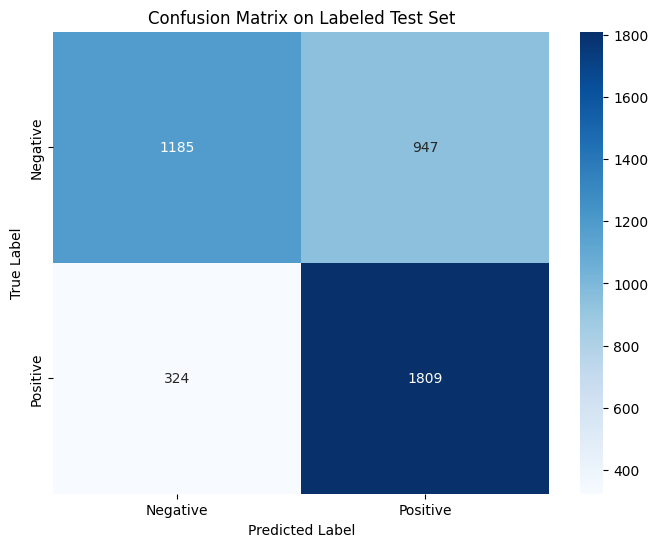

## Generate Competition Submission File

Now that we've evaluated our model's performance on the labeled test set, let's generate predictions for the competition submission using the unlabeled test set.

The following cells will:
1. Load the test data from `test_set.csv`
2. Preprocess the test data using the same tokenizer
3. Generate predictions using the trained model
4. Create a submission CSV file with `id` and `pred` columns


In [54]:
# Load test data for submission
test_submission = pd.read_csv('/kaggle/input/testdata/test_set.csv')
print(f"Test data shape: {test_submission.shape}")
print(test_submission.head())


Test data shape: (4265, 2)
     id                                               text
0  7899  as predictable as the outcome of a globetrotte...
1  1050  visually imaginative , thematically instructiv...
2  6016  don't be fooled by the impressive cast list - ...
3  6089               has all the depth of a wading pool .
4  1695  lookin' for sin , american-style ? try hell ho...


In [55]:
# Check column names and rename if necessary
print("Column names:", test_submission.columns.tolist())

# If the text column has a different name (like 'review'), rename it to 'text'
# Adjust this based on your actual column names
if 'review' in test_submission.columns and 'text' not in test_submission.columns:
    test_submission = test_submission.rename(columns={'review': 'text'})
    print("Renamed 'review' column to 'text'")
elif 'Text' in test_submission.columns and 'text' not in test_submission.columns:
    test_submission = test_submission.rename(columns={'Text': 'text'})
    print("Renamed 'Text' column to 'text'")
    
# Ensure 'id' column exists
if 'ID' in test_submission.columns and 'id' not in test_submission.columns:
    test_submission = test_submission.rename(columns={'ID': 'id'})
    print("Renamed 'ID' column to 'id'")
    
print("\nUpdated column names:", test_submission.columns.tolist())


Column names: ['id', 'text']

Updated column names: ['id', 'text']


In [56]:
# Create test dataset from submission data
# Assuming the test data has an 'id' column and a 'text' column (adjust column name if different)
test_submission_ds = Dataset.from_pandas(test_submission, split="test")

# Tokenize test data
tokenized_test_submission = test_submission_ds.map(preprocess_function, batched=True)
print("Test data tokenized successfully!")


Map:   0%|          | 0/4265 [00:00<?, ? examples/s]

Test data tokenized successfully!


In [57]:
# Generate predictions on test data
test_predictions = trainer.predict(tokenized_test_submission)

# Extract predicted labels (0 or 1)
predictions = np.argmax(test_predictions.predictions, axis=1)
print(f"Generated {len(predictions)} predictions")


Generated 4265 predictions


In [58]:
# Create submission DataFrame with required format
submission = pd.DataFrame({
    'id': test_submission['id'],
    'pred': predictions
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")
print(f"Submission shape: {submission.shape}")
print("\nFirst few rows:")
print(submission.head())
print("\nPrediction distribution:")
print(submission['pred'].value_counts())


Submission file created successfully!
Submission shape: (4265, 2)

First few rows:
     id  pred
0  7899     1
1  1050     1
2  6016     0
3  6089     1
4  1695     0

Prediction distribution:
pred
1    2804
0    1461
Name: count, dtype: int64


In [59]:
# Verify submission file format
verify_submission = pd.read_csv('submission.csv')
print("Submission file columns:", verify_submission.columns.tolist())
print("\nExample format (should match competition requirements):")
print("id,pred")
print(f"{verify_submission.iloc[0]['id']},{verify_submission.iloc[0]['pred']}")
print(f"{verify_submission.iloc[1]['id']},{verify_submission.iloc[1]['pred']}")
print("...")


Submission file columns: ['id', 'pred']

Example format (should match competition requirements):
id,pred
7899,1
1050,1
...
